## References:

"Hello World Deep Learning in Medical Imaging" by Paras Lakhani, Daniel L. Gray, Carl R. Pett, Paul Nagy & George Shih [at the following link](https://link.springer.com/article/10.1007/s10278-018-0079-6);

"Hello_World_Deep_Learning" Github implementation by Paras Lakhani and X-ray dataset are available at this [link](https://github.com/paras42/Hello_World_Deep_Learning);

##Setup

In [1]:
# Project Folder:
%cd '/content/drive/MyDrive/Chest_X_Ray_vs_Abd'

/content/drive/MyDrive/Chest_X_Ray_vs_Abd


In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.11.0
GPU is available


In [3]:
# Clear Memory
from keras import backend as K
K.clear_session()

## Select the TF2 SavedModel module to use
TF2 models that generate image feature vectors, can be found [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2);

In [4]:
module_selection = ("efficientnet/b2/classification", 260)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 5

Using https://tfhub.dev/google/imagenet/efficientnet/b2/classification/feature_vector/4 with input size (260, 260)


## Dataset Setup

In [5]:
# Load the data

base_dir = '/content/drive/MyDrive/Chest_X_Ray_vs_Abd'
train_dir = os.path.join(base_dir, 'TRAIN')
test_dir = os.path.join(base_dir, 'TEST')

In [6]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = datagen.flow_from_directory(
    train_dir, subset="validation", shuffle=False, **dataflow_kwargs)
test_generator = datagen.flow_from_directory(
    test_dir, shuffle=False, **dataflow_kwargs)

do_data_augmentation = True

if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = datagen
train_generator = train_datagen.flow_from_directory(
    train_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 14 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


##Define the Model

In [7]:
do_fine_tuning = False

In [8]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    #hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4", trainable=do_fine_tuning),
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b2/classification/1", trainable=do_fine_tuning),
    tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(train_generator.num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet/b2/classification/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1000)              9177562   
_________________________________________________________________
dense (Dense)                (None, 2048)              2050048   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
____________________

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint('./model_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True)

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

##Train the Model

In [11]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=25, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks = [checkpoint, es]).history

Epoch 1/25
12/12 [==============================] - 61s 2s/step - loss: 1.0347 - accuracy: 0.5426 - val_loss: 0.9318 - val_accuracy: 0.5000
Epoch 2/25
12/12 [==============================] - 2s 128ms/step - loss: 0.9025 - accuracy: 0.5655 - val_loss: 0.7154 - val_accuracy: 1.0000
Epoch 3/25
12/12 [==============================] - 1s 122ms/step - loss: 0.6714 - accuracy: 0.8585 - val_loss: 0.4211 - val_accuracy: 1.0000
Epoch 4/25
12/12 [==============================] - 2s 124ms/step - loss: 0.5170 - accuracy: 0.9472 - val_loss: 0.6739 - val_accuracy: 0.8000
Epoch 5/25
12/12 [==============================] - 1s 120ms/step - loss: 0.3795 - accuracy: 0.9882 - val_loss: 0.6626 - val_accuracy: 0.8000
Epoch 6/25
12/12 [==============================] - 1s 121ms/step - loss: 0.4194 - accuracy: 0.9749 - val_loss: 0.4453 - val_accuracy: 0.9000
Epoch 7/25
12/12 [==============================] - 2s 160ms/step - loss: 0.4071 - accuracy: 0.9623 - val_loss: 0.5318 - val_accuracy: 0.9000
Epoch 8/

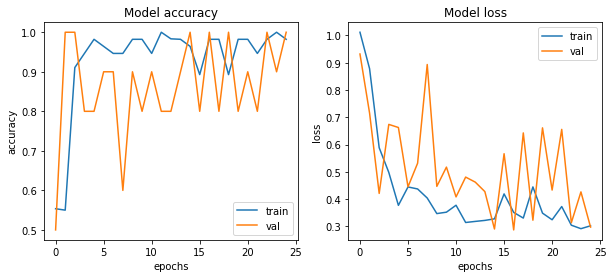

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist[met])
    ax[i].plot(hist['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

##Evaluate the Model

In [13]:
test_loss, test_score = model.evaluate(test_generator, batch_size=1)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

2/2 [==============================] - 3s 3s/step - loss: 0.3291 - accuracy: 1.0000
Loss on test set:  0.32911625504493713
Accuracy on test set:  1.0


## Model prediction on test data

In [14]:
labels = (train_generator.class_indices)
print(labels)

{'openI_abdominal_xray': 0, 'openI_chest_xray': 1}


Found 10 images belonging to 2 classes.


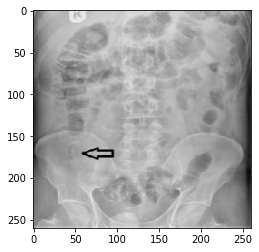

correct class:  openI_abdominal_xray
predicted class: openI_abdominal_xray


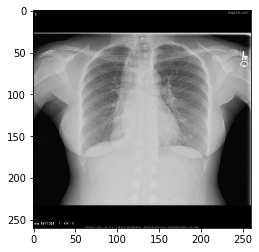

correct class:  openI_chest_xray
predicted class: openI_chest_xray


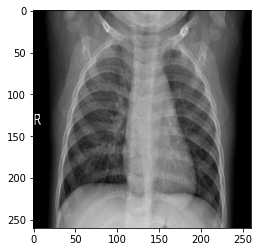

correct class:  openI_chest_xray
predicted class: openI_chest_xray


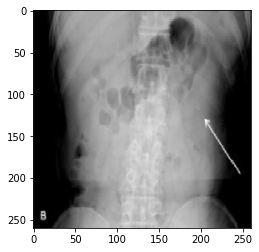

correct class:  openI_abdominal_xray
predicted class: openI_chest_xray


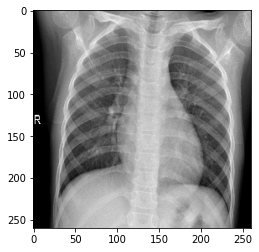

correct class:  openI_chest_xray
predicted class: openI_chest_xray


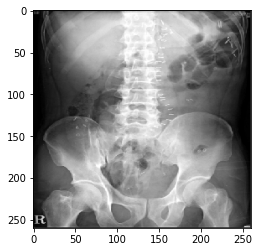

correct class:  openI_abdominal_xray
predicted class: openI_abdominal_xray


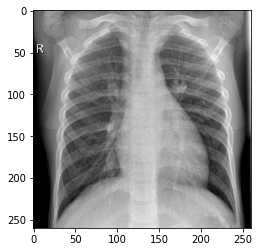

correct class:  openI_chest_xray
predicted class: openI_chest_xray


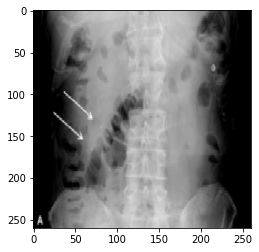

correct class:  openI_abdominal_xray
predicted class: openI_abdominal_xray


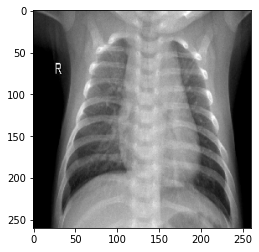

correct class:  openI_chest_xray
predicted class: openI_chest_xray


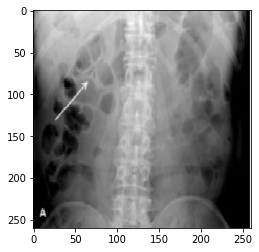

correct class:  openI_abdominal_xray
predicted class: openI_abdominal_xray


In [15]:
img_width, img_height = 260, 260

test_generator_2 = datagen.flow_from_directory(
test_dir,
target_size=(img_width, img_height),
batch_size=1,
class_mode='categorical')

for n in range(10):
  _ = test_generator_2.next()
  image, classifier = (_[0][0],_[1][0])
  index = np.argmax(classifier)
  answer = list(test_generator_2.class_indices.keys())[index]
  predicted = model.predict(np.asarray([image]))
  predicted_answer_index = np.argmax(predicted[0])
  predicted_answer = list(test_generator_2.class_indices.keys())[predicted_answer_index]
  plt.imshow(image)
  plt.show()

  print('correct class: ', answer)
  print('predicted class:', predicted_answer)